In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import os
import numpy as np
import typing
from sklearn.model_selection import train_test_split
import time
from collections import defaultdict
from torchvision.models import resnet18

In [12]:
# Директория с тренировочными данными
train_data_dir = "drive/MyDrive/butter/train_butterflies/train_split"

classes_dirs = [cls for cls in os.listdir(train_data_dir) if os.path.isdir(f"{train_data_dir}/{cls}")]

all_train_paths = [
    f"{train_data_dir}/{cls}/{p}"
    for cls in classes_dirs
    for p in os.listdir(f"{train_data_dir}/{cls}")
    if os.path.isfile(f"{train_data_dir}/{cls}/{p}")
]

# Извлекаем метки классов из путей (название директории — это метка)
classes_labels = [p.split("/")[-2] for p in all_train_paths]

print(len(classes_dirs)) # Кол-во классов
print(len(all_train_paths)) # Кол-во изображений тренировочных

test_data_dir = "drive/MyDrive/butter/test_butterflies"
all_test_paths = [p for p in os.listdir(test_data_dir+"/valid")]

print(len(all_test_paths)) # Кол-во изображений тестовых


50
4955
250


In [ ]:
train_paths, val_paths = train_test_split(all_train_paths, test_size=0.2, random_state=51, stratify=classes_labels)

In [ ]:
img_size = 224

train_transforms = tv.transforms.Compose([
    tv.transforms.Resize(img_size),
    tv.transforms.CenterCrop(img_size), # Обрезаем по цетру до 224х224
    tv.transforms.ColorJitter(0.6, 0.8, 0.7), # Изменяем яркость, контраст и насыщенность
    tv.transforms.RandomAffine(10), # Случайный поворот изображения на ±10 градусов
    tv.transforms.ToTensor()
])

val_transforms = tv.transforms.Compose([
    tv.transforms.Resize(img_size),
    tv.transforms.CenterCrop(img_size),
    tv.transforms.ToTensor()
])

# Создаем тренировочный набор данных
train_dataset = tv.datasets.ImageFolder(
    train_data_dir,
    transform=train_transforms,
    is_valid_file=lambda x: x in train_paths
)

# Создаем валидационный набор данных
val_dataset = tv.datasets.ImageFolder(
    train_data_dir,
    transform=val_transforms,
    is_valid_file=lambda x: x in val_paths
)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
def plot_learning_curves(history):
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Loss', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('loss', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Accuracy', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('loss', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
def train(model, criterion, optimizer, train_batch_gen, val_batch_gen,num_epochs=10):
    history = defaultdict(lambda: defaultdict(list)) # Словарь для истории

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()
        model.train()

        for X_batch, y_batch in train_batch_gen:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Перенос на устройство
            logits = model(X_batch) # Предсказания модели для текущего батча

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward() # Обратное распространение
            optimizer.step() # Обновление весов
            optimizer.zero_grad() # Обнуление градиентов

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        model.eval() # Режим валидации

        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

    return model, history

In [ ]:
batch_size = 32

# Генераторы батчей
train_batch_gen = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Определяем модель для тонкой настройки
fine_tuning_model = nn.Sequential() # контейнер, позволяющий последовательно добавлять слои в модель

# Количество классов в выходном слое
classes_count = len(train_dataset.classes)

# Добавляем предобученную модель ResNet18 с заменой верхних слоев
fine_tuning_model.add_module('resnet', resnet18(pretrained=True)) # Базовая модель ResNet18, 1 слой
fine_tuning_model.add_module('relu_1', nn.ReLU()) # Дополнительный ReLU слой, 2 слой
fine_tuning_model.add_module('fc_1', nn.Linear(1000, classes_count)) # Финальный линейный слой для классификации на classes_count классов, 3 слой
fine_tuning_model = fine_tuning_model.to(device)

Epoch 1 of 6 took 46.891s
  training loss (in-iteration): 	1.905385
  validation loss (in-iteration): 	0.653544
  training accuracy: 			54.18 %
  validation accuracy: 			83.24 %
Epoch 2 of 6 took 45.333s
  training loss (in-iteration): 	0.521585
  validation loss (in-iteration): 	0.392527
  training accuracy: 			86.56 %
  validation accuracy: 			89.69 %
Epoch 3 of 6 took 44.123s
  training loss (in-iteration): 	0.305727
  validation loss (in-iteration): 	0.307690
  training accuracy: 			91.68 %
  validation accuracy: 			91.93 %
Epoch 4 of 6 took 44.518s
  training loss (in-iteration): 	0.211237
  validation loss (in-iteration): 	0.289822
  training accuracy: 			94.05 %
  validation accuracy: 			92.93 %
Epoch 5 of 6 took 44.292s
  training loss (in-iteration): 	0.157824
  validation loss (in-iteration): 	0.285806
  training accuracy: 			95.82 %
  validation accuracy: 			92.13 %
Epoch 6 of 6 took 44.674s
  training loss (in-iteration): 	0.125938
  validation loss (in-iteration): 	0.24853

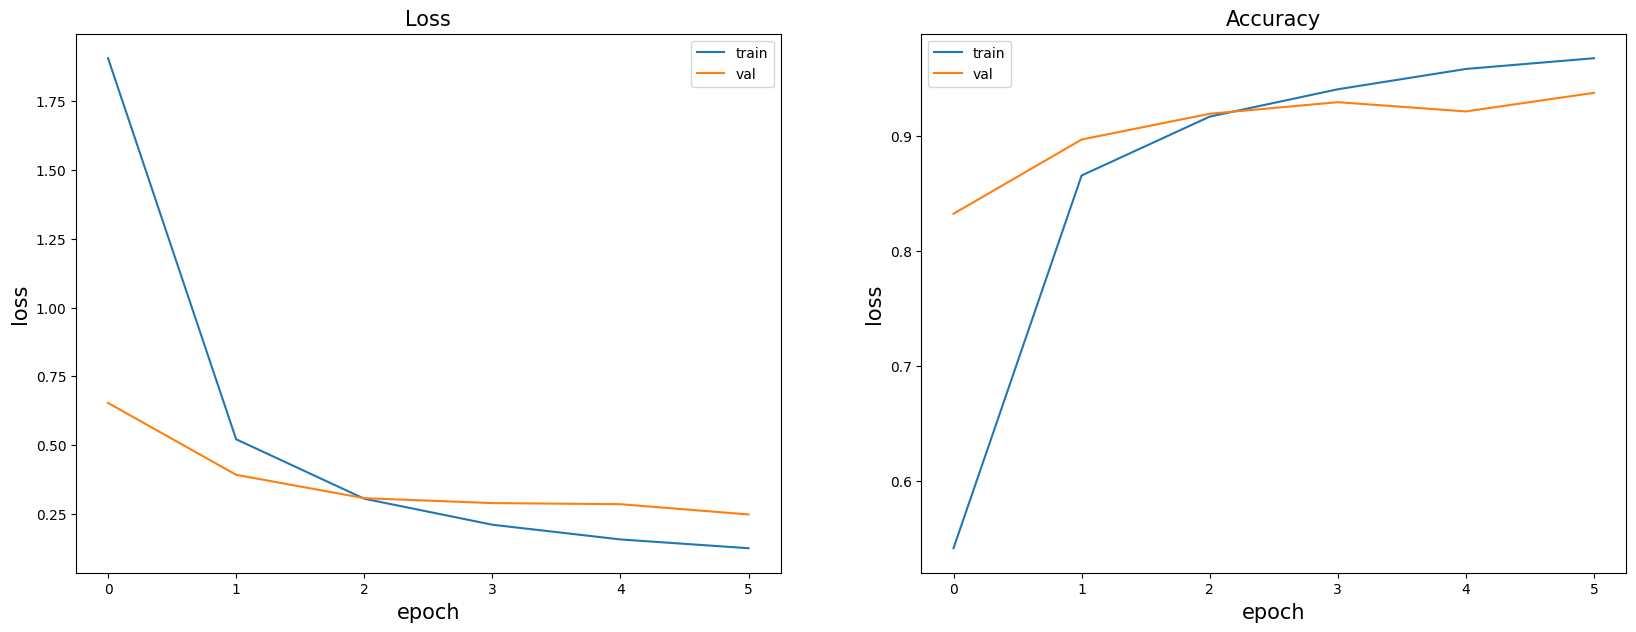

In [ ]:
# # Определяем функцию потерь для классификации (кросс-энтропия)
criterion = nn.CrossEntropyLoss()
lr = 0.01 # # Скорость обучения
optim = torch.optim.SGD(fine_tuning_model.parameters(), lr) # Используем стохастический градиентный спуск (SGD)

clf, history = train(fine_tuning_model, criterion, optim, train_batch_gen, val_batch_gen, 6)
plot_learning_curves(history)

In [ ]:
# Загрузка тестового набора данных
test_dataset = tv.datasets.ImageFolder(
    test_data_dir,
    transform=val_transforms,
)

# Генератор Батчей
test_batch_gen = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

In [ ]:
# Оценка модели на тестовом наборе
fine_tuning_model.eval()
pred: list = []
for X_batch in test_batch_gen:
    X_batch = X_batch[0]
    X_batch = X_batch.to(device)

    logits: torch.Tensor = fine_tuning_model(X_batch)
    pred.extend(logits.max(1)[1].detach().cpu().numpy())

In [ ]:
# Создание списка классов (ну они и придумали формат)
classes = [f"class_{i}" for i in range(50)]
classes.sort()

# Словарь для перевода индексов в имена классов
fix = {i: cls for i, cls in enumerate(classes)}

In [ ]:
# Функция для преобразования индекса в исходный номер класса
def lex_to_orig(i) -> int:
    return fix[i].split('_')[-1]

In [ ]:
output = pd.DataFrame({
    "index": [obj[0].split("/")[-1].split(".jpg")[0] for obj in test_dataset.imgs],
    "label": pred,
})

In [ ]:
# Преобразуем метки в исходные номера классов
output["label"] = output["label"].apply(lex_to_orig)
output

,index,label
0,0,14
1,1,40
2,10,38
3,100,1
4,101,48
...,...,...
245,95,48
246,96,2
247,97,7
248,98,0


In [ ]:
output.to_csv("submission.csv", index=False)

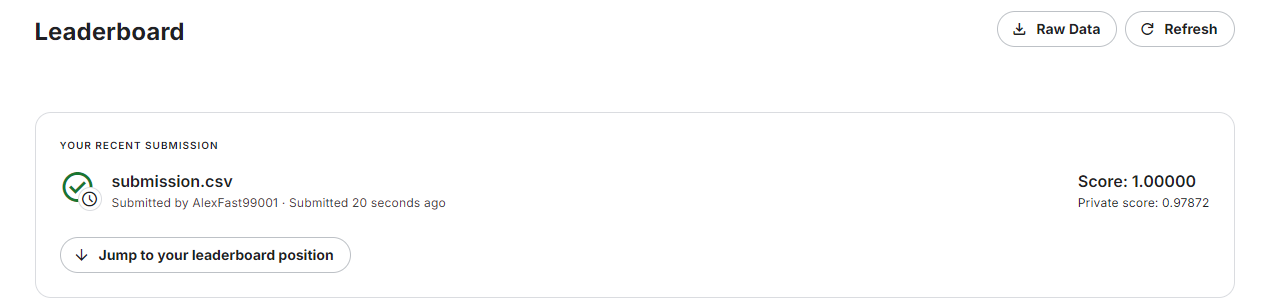